# Products/Category Exploratory Data Analysis

**Goal:** to find the product categories that repeatedly underperform vs others, and understand the reasons behind it

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 - Data Preparation

In [5]:
from olist.product import Product
products = Product().get_training_data()

# Compute the volume of the product because it will might play a role on the review score
# Heavy object is hard to ship, etc. 

products['product_volume_cm3'] = products["product_length_cm"] * products["product_height_cm"] * products["product_width_cm"]

products.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,...,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,...,0.0,1.0,5.0,0,1,1,10.91,1.091,1.091,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,15.771898,...,0.0,1.0,5.0,0,1,1,248.00,24.800,24.800,10800.0
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,2.087674,...,0.0,1.0,5.0,0,1,1,79.80,7.980,7.980,2430.0
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,3.262986,...,1.0,0.0,1.0,100,1,1,112.30,11.230,-88.770,2704.0
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,2.899387,...,0.0,1.0,5.0,0,1,1,37.90,3.790,3.790,4420.0


## 2 - Analysis per individual products

### 2.1 - Inspect distribution of each product features using histograms

Text(0.5, 0.98, 'Distribution of each product features')

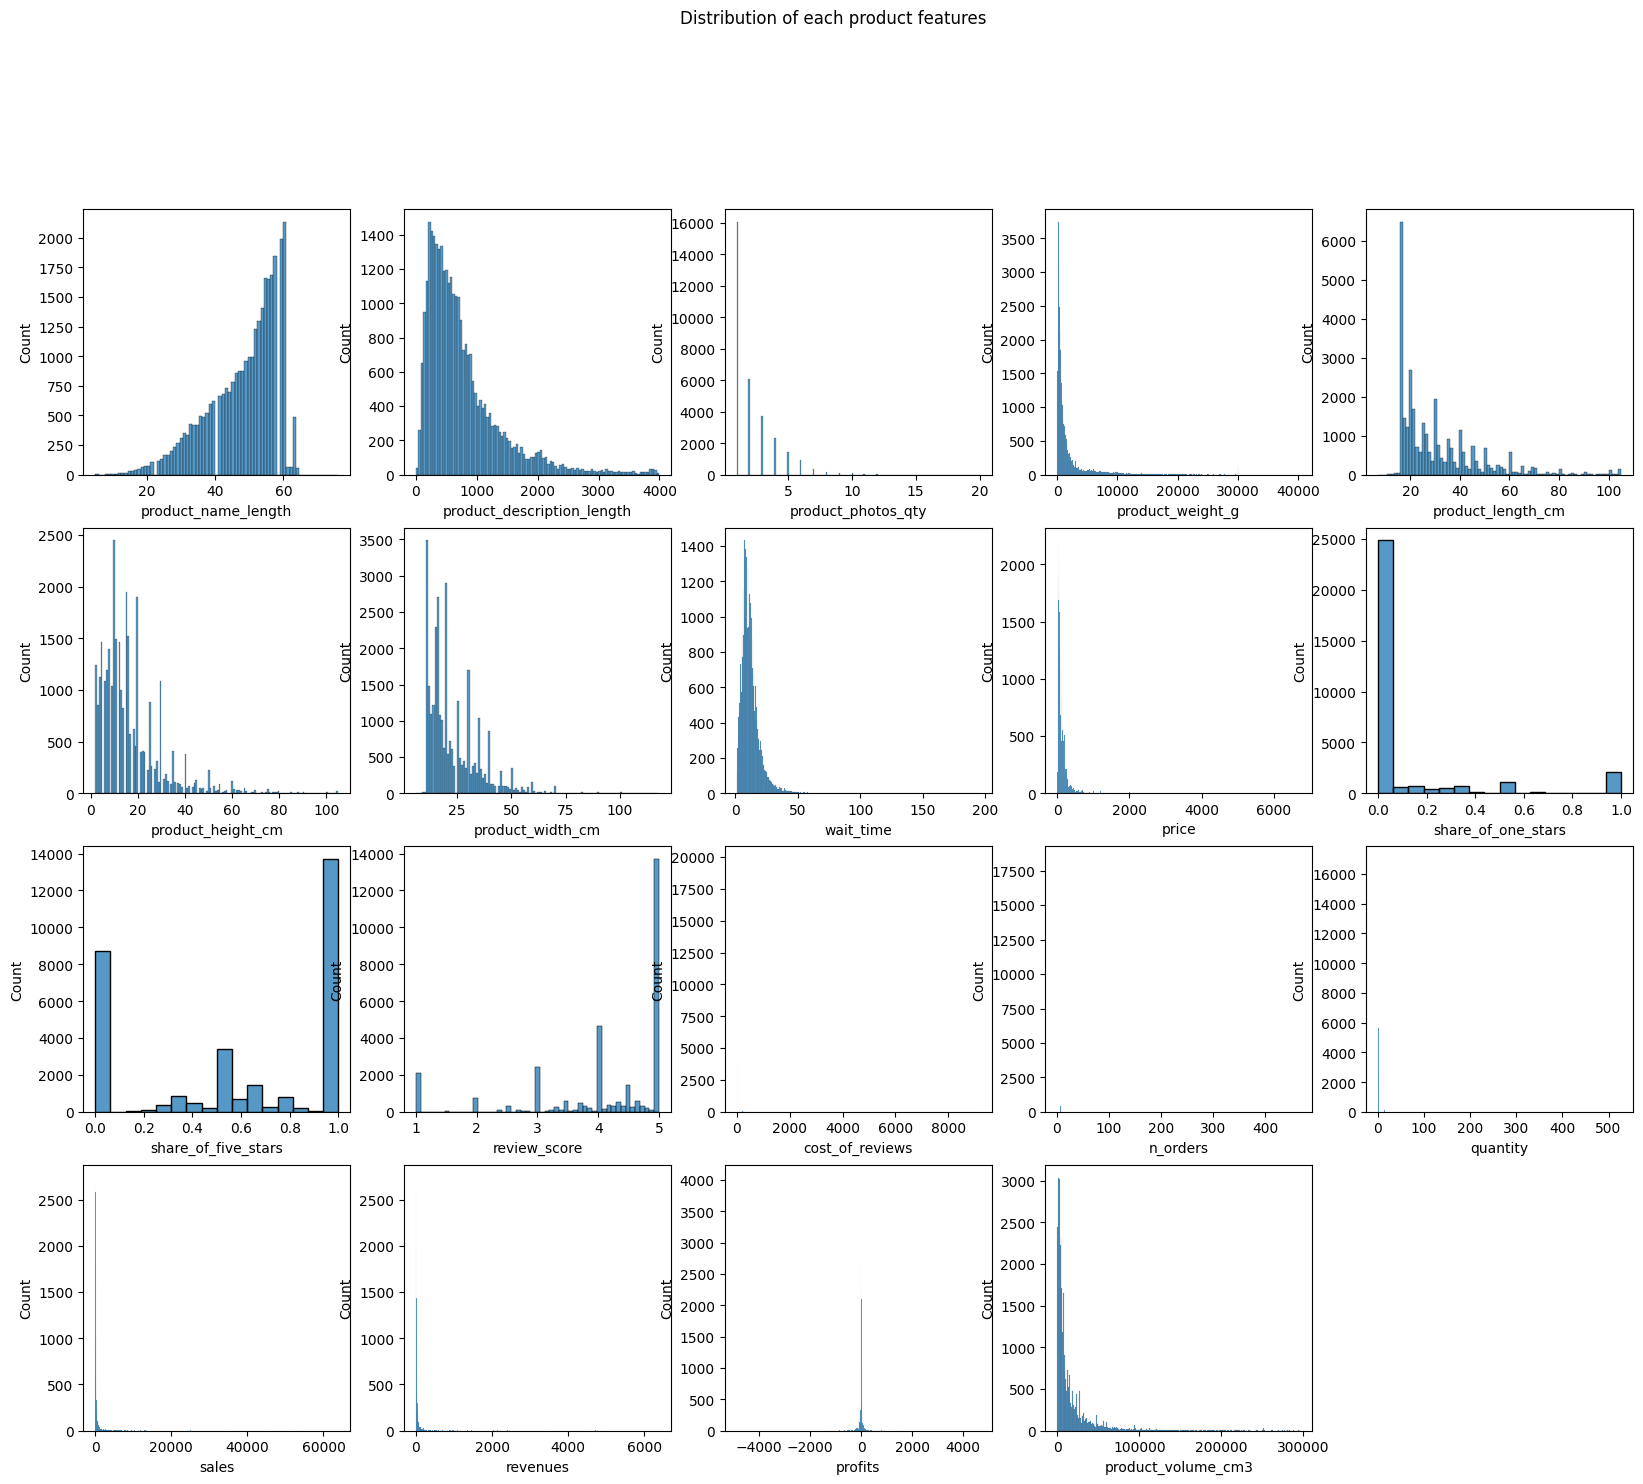

In [6]:
plt.figure(figsize=(20,20))
for (i, col) in enumerate(products.set_index('product_id').drop(columns='category').columns):
    plt.subplot(5,5,i+1)
    sns.histplot(products[col])
plt.suptitle("Distribution of each product features")

**💡 Findings:**
- share_of_one_stars: There seems to be a `group of products` which stands out for having `very low review scores`!

(-0.1, 1.1)

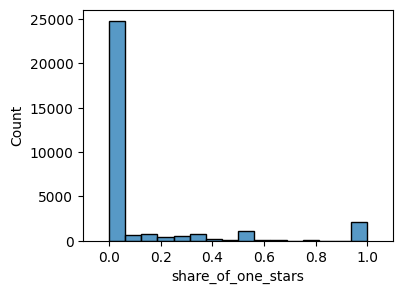

In [7]:
plt.figure(figsize=(4,3))
sns.histplot(data=products,x='share_of_one_stars')
plt.xlim(-0.1,1.1)

### 2.1 - Visuliazing the relationship between product features and average review score

**❓ Questions to Answer:**
- Which particular products or categories tend to have low review scores?
- Why do they have low review scores?

In [8]:
import plotly.express as px
fig = px.scatter(data_frame = products,
    x="wait_time",
    y="product_volume_cm3",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5,
    hover_name="category"
)
fig.show(renderer='iframe')

**💡 Findings:**
- Seems like many products with low review scores have a higher wait_time and product_volume_cm3

## 2.2 - Predicting the average review_score per product_id

📝 Steps: 
- Model review_score with an OLS
- Choose features to use to predict the review score
    - Are the features linearly correlated?
    - what is the R^2 of the model?
    - Among the features, which ones are the most important/significant?

📊 Let's first see how the features are **`linearly correlated`**

In [7]:
# selecting the features that I want to check
features = ['product_name_length',
 'product_description_length',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'wait_time',
 'price',
 'review_score',
 'cost_of_reviews',
 'n_orders',
 'quantity',
 'sales',
 'product_volume_cm3']

<AxesSubplot: >

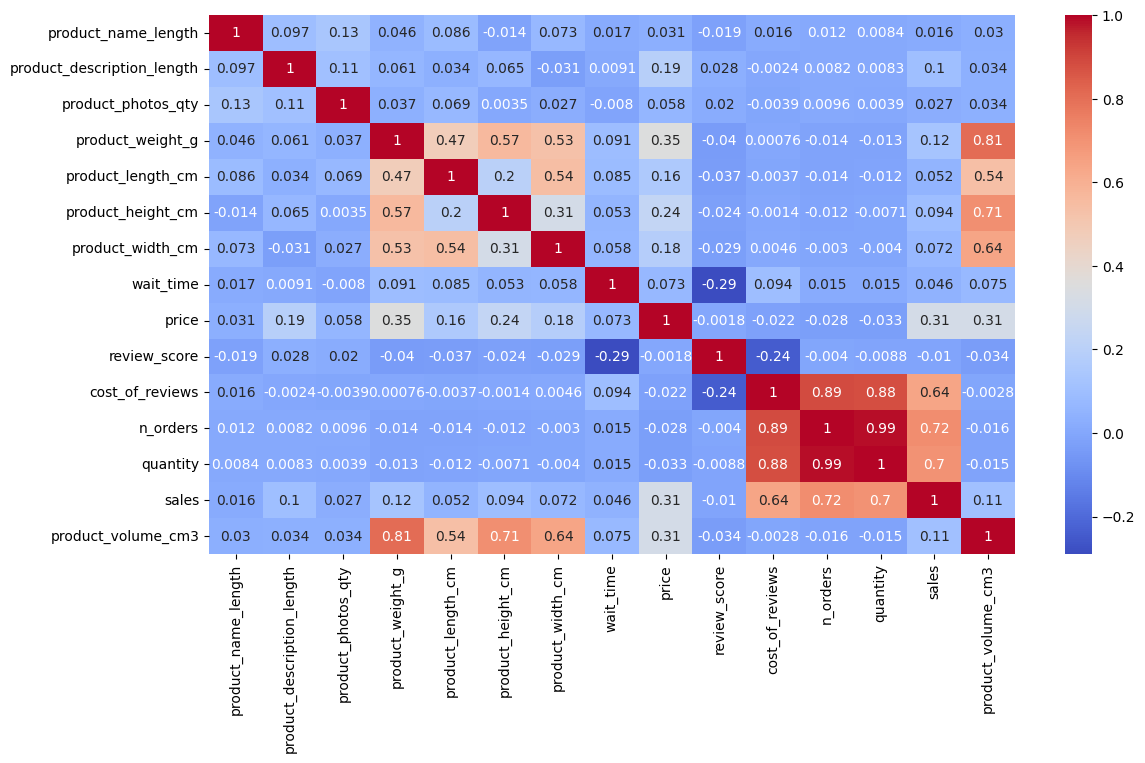

In [8]:
plt.figure(figsize = (13,7))

sns.heatmap(products.loc[:,features].corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10})

💡 Some interesting features to consider:
* `product_photos_qty` : the more pictures available, the more likely you will make the decision to purchase it?
* `product_description_length` : the more description available, the more likely you will make the decision to purchase it?
* `product_volume_cm3` : it is faster to ship a smaller product than a larger one (e.g., furnitures)?
* `wait_time` : are Olist' customers patient ?
* `price` : how does the price of a product influence a customer's satisfaction ?
* `n_orders` : it might indicate whether a product is popular or not
* `quantity` : same thing

📊 Pick the features to use in **linear regression** model

⚖  **Standardize** the features in order to make the partial regression coefficients comparable

In [9]:
# Use Sklearn's StandardScaler for quick standardization
from sklearn.preprocessing import StandardScaler
products_selected_features = [
    'product_photos_qty',
    'product_description_length',
    'product_volume_cm3',
    'wait_time',
    'price',
    #'n_orders', 
    'quantity'
]
scaler = StandardScaler()
products_standardized = products.copy()
products_standardized[products_selected_features] = scaler.fit_transform(products[products_selected_features])
products_standardized.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,...,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,-0.763254,-0.684394,225.0,16.0,10.0,14.0,perfumery,-1.101824,...,0.0,1.0,5.0,0,1,-0.231053,10.91,1.091,1.091,-0.530177
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,-0.780574,-0.684394,1000.0,30.0,18.0,20.0,art,0.441232,...,0.0,1.0,5.0,0,1,-0.231053,248.00,24.800,24.800,-0.210459
2,96bd76ec8810374ed1b65e291975717f,46.0,-0.821513,-0.684394,154.0,18.0,9.0,15.0,sports_leisure,-1.214334,...,0.0,1.0,5.0,0,1,-0.231053,79.80,7.980,7.980,-0.523081
3,cef67bcfe19066a932b7673e239eb23d,27.0,-0.804193,-0.684394,371.0,26.0,4.0,26.0,baby,-1.072141,...,1.0,0.0,1.0,100,1,-0.231053,112.30,11.230,-88.770,-0.512847
4,9dc1a7de274444849c219cff195d0b71,37.0,-0.582180,1.040600,625.0,20.0,17.0,13.0,housewares,-1.116130,...,0.0,1.0,5.0,0,1,-0.231053,37.90,3.790,3.790,-0.448754


👉 Run VIF Analysis to analyze the potential multicolinearities: 

- Cannot use both n_order and quantity in OLS because vif index is blown out
- Other selected features look fine (~1) as per below

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_df = products_standardized[products_selected_features].dropna()
vif(vif_df.values,0)
df = pd.DataFrame()
df["features"] = vif_df.columns
df["vif_index"] = [vif(vif_df.values, i) for i in range(vif_df.shape[1])]
round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
4,price,1.15
2,product_volume_cm3,1.11
1,product_description_length,1.05
0,product_photos_qty,1.01
3,wait_time,1.01
5,quantity,1.00


📈 Run the OLS on the selected features to predict the review scores

In [11]:
import statsmodels.formula.api as smf
formula = 'review_score' + ' ~ ' + ' + '.join(products_selected_features)
model = smf.ols(formula = formula, data = products_standardized.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     491.5
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:27:05   Log-Likelihood:                -47607.
No. Observations:               31481   AIC:                         9.523e+04
Df Residuals:                   31474   BIC:                         9.529e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.1101      0.006    664.208      0.000       4.098       4.122
product_photos_qty             0.0164      0.006      2.637      0.008       0.004       0.029
product_description_length     0.0300      0.006      4.734      0.000       0.018       0.042
product_volume_cm3            -0.0230      0.007     -3.524      0.000      -0.036      -0.010
wait_time                     -0.3327      0.006    -53.520      0.000      -0.345      -0.320
price                          0.0221      0.007      3.329      0.001       0.009       0.035
quantity                      -0.0051      0.006     -0.829      0.407      -0.017       0.007
==============================================================================
Omnibus:                     6848.663   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13823.198
Skew:                          -1.304   Prob(JB):                         0.00
Kurtosis:                       4.934   Cond. No.                         1.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

📊 Visuliazing each coefficients

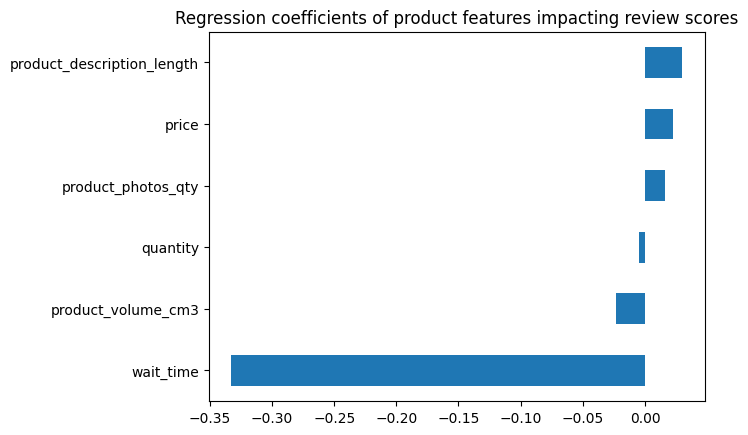

In [13]:
model.params[1:].sort_values().plot(kind='barh')
plt.title('Regression coefficients of product features impacting review scores')
plt.show()

**Some insight based on the OLS analysis**

🎉 Almost all the p-values are lower than 5%, which means than almost all our coefficients are statistically significant (except for quantity)! 

ℹ️ The `price` has a small but positive impact on the review score. Is it a psychological effect when customers do not want to admit a product is bad because they paid a certain amount of money on it ?

😮 The `number of photos` and `length of descriptio`n both have small positive impact on review score but not so much. 


ℹ️ The `product volume` does not seem to have a big impact on the review score, but the impact is still slightly negative. 

🔴 The `wait_time` has a huge negative impact on the review_score.


# 3 - Analysis per product category

Now, instead of looking at each products independently, let's group them by category and run a similar analysis. 

## 3.1 Build an aggregated dataframe with a get_product_cat function

👉 Created a function `get_product_cat` on olist.product.py which:
* takes an `aggregating method as an argument` (choose the `mean` by default)
* returns a DataFrame with:
    * each `product_category`'s `quantity` summed 
    * all other numerical features aggregated by the chosen method.
 

For instance get_product_cat('median') returns:

      - `quantity` (sum)
      - `wait_time` (median)
      - `review_score` (median)
      - `price` (median)
      - ....

In [15]:
def get_product_cat(agg='mean'):
    columns = list(products.select_dtypes(exclude=['object']).columns)
    agg_params = dict(zip(columns,[agg] * len(columns)))
    agg_params['quantity'] = 'sum'
    agg_params['sales'] = 'sum'

    return products.groupby('category').agg(agg_params)
    
product_cat = get_product_cat().reset_index()
product_cat.head()

,category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits,product_volume_cm3
0,agro_industry_and_commerce,49.225352,780.943662,2.267606,5430.873239,36.422535,29.126761,26.422535,11.602829,441.921263,0.115982,0.455186,3.924322,36.901408,2.535211,209,71443.60,100.624789,63.723380,38766.605634
1,air_conditioning,51.675000,921.691667,2.200000,4547.858333,36.841667,23.833333,26.200000,11.461313,208.906065,0.145010,0.565236,3.991434,34.250000,2.075000,291,54285.16,45.237633,10.987633,28288.333333
2,art,48.019608,720.156863,2.215686,1714.647059,36.098039,10.803922,23.392157,10.477878,207.937102,0.101494,0.687021,4.307236,64.117647,3.862745,199,23859.94,46.784196,-17.333451,9821.313725
3,arts_and_craftmanship,44.263158,620.421053,3.000000,1164.578947,28.368421,9.789474,21.052632,5.356206,65.839474,0.073684,0.694737,4.357895,22.105263,1.263158,24,1814.01,9.547421,-12.557842,6895.947368
4,audio,46.551724,781.965517,2.034483,641.637931,20.827586,11.500000,17.344828,13.360079,116.488832,0.201186,0.539507,3.755233,139.137931,6.034483,364,50688.50,87.393966,-51.743966,4970.172414


## 3.2 - Which categories are sold the most on Olist? Which categories are sold the least?

In [16]:
top_20_quantity = product_cat.loc[:,['category','quantity']].\
                sort_values(by='quantity',ascending=False).head(20)
top_20_quantity

,category,quantity
7,bed_bath_table,11046
43,health_beauty,9606
65,sports_leisure,8570
39,furniture_decor,8223
15,computers_accessories,7766
49,housewares,6875
70,watches_gifts,5953
68,telephony,4514
42,garden_tools,4310
5,auto,4156


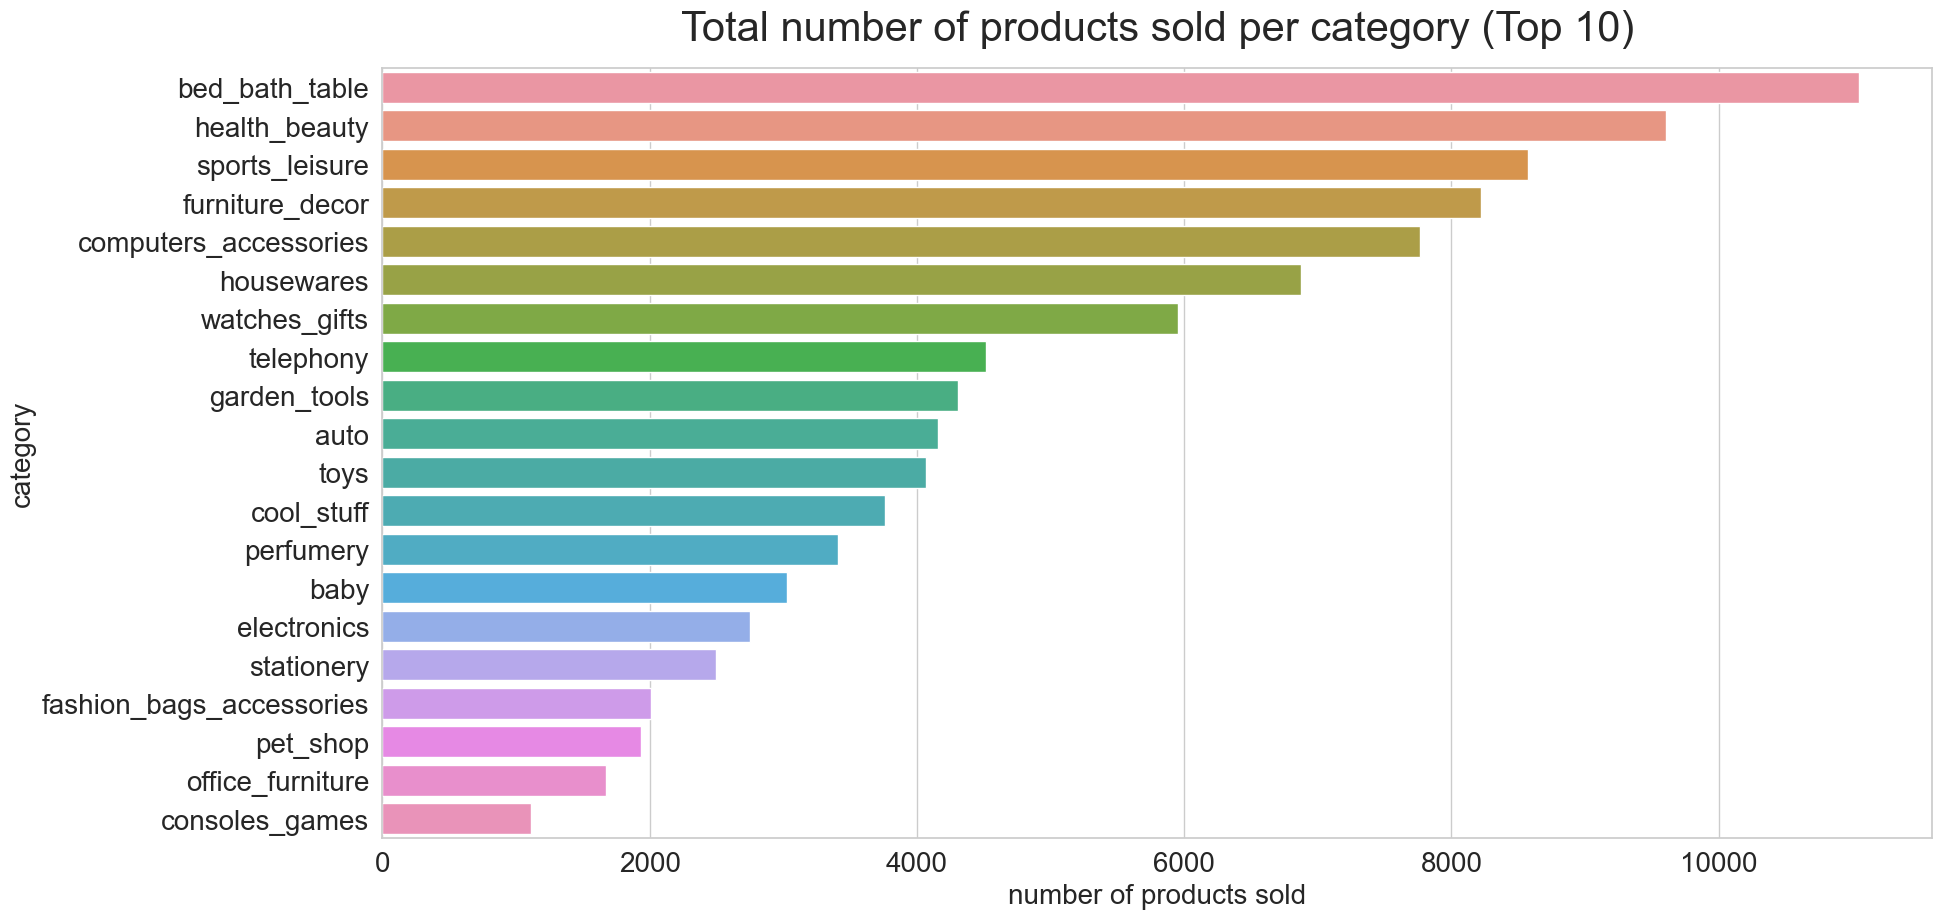

In [17]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize = (20,10))
sns.barplot(y = top_20_quantity['category'],x=top_20_quantity['quantity'])
plt.title('Total number of products sold per category (Top 10)', fontsize = 30, pad = 20)

plt.xlabel('number of products sold',fontsize=20)
plt.ylabel('category',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [18]:
bottom_20_quantity = product_cat.loc[:,['category','quantity']].\
                sort_values(by='quantity',ascending=False).tail(20)
bottom_20_quantity

,category,quantity
38,furniture_bedroom,106
22,costruction_tools_tools,103
67,tablets_printing_image,82
64,small_appliances_home_oven_and_coffee,75
13,cine_photo,70
25,dvds_blu_ray,62
9,books_imported,59
27,fashio_female_clothing,47
58,party_supplies,42
41,furniture_mattress_and_upholstery,38


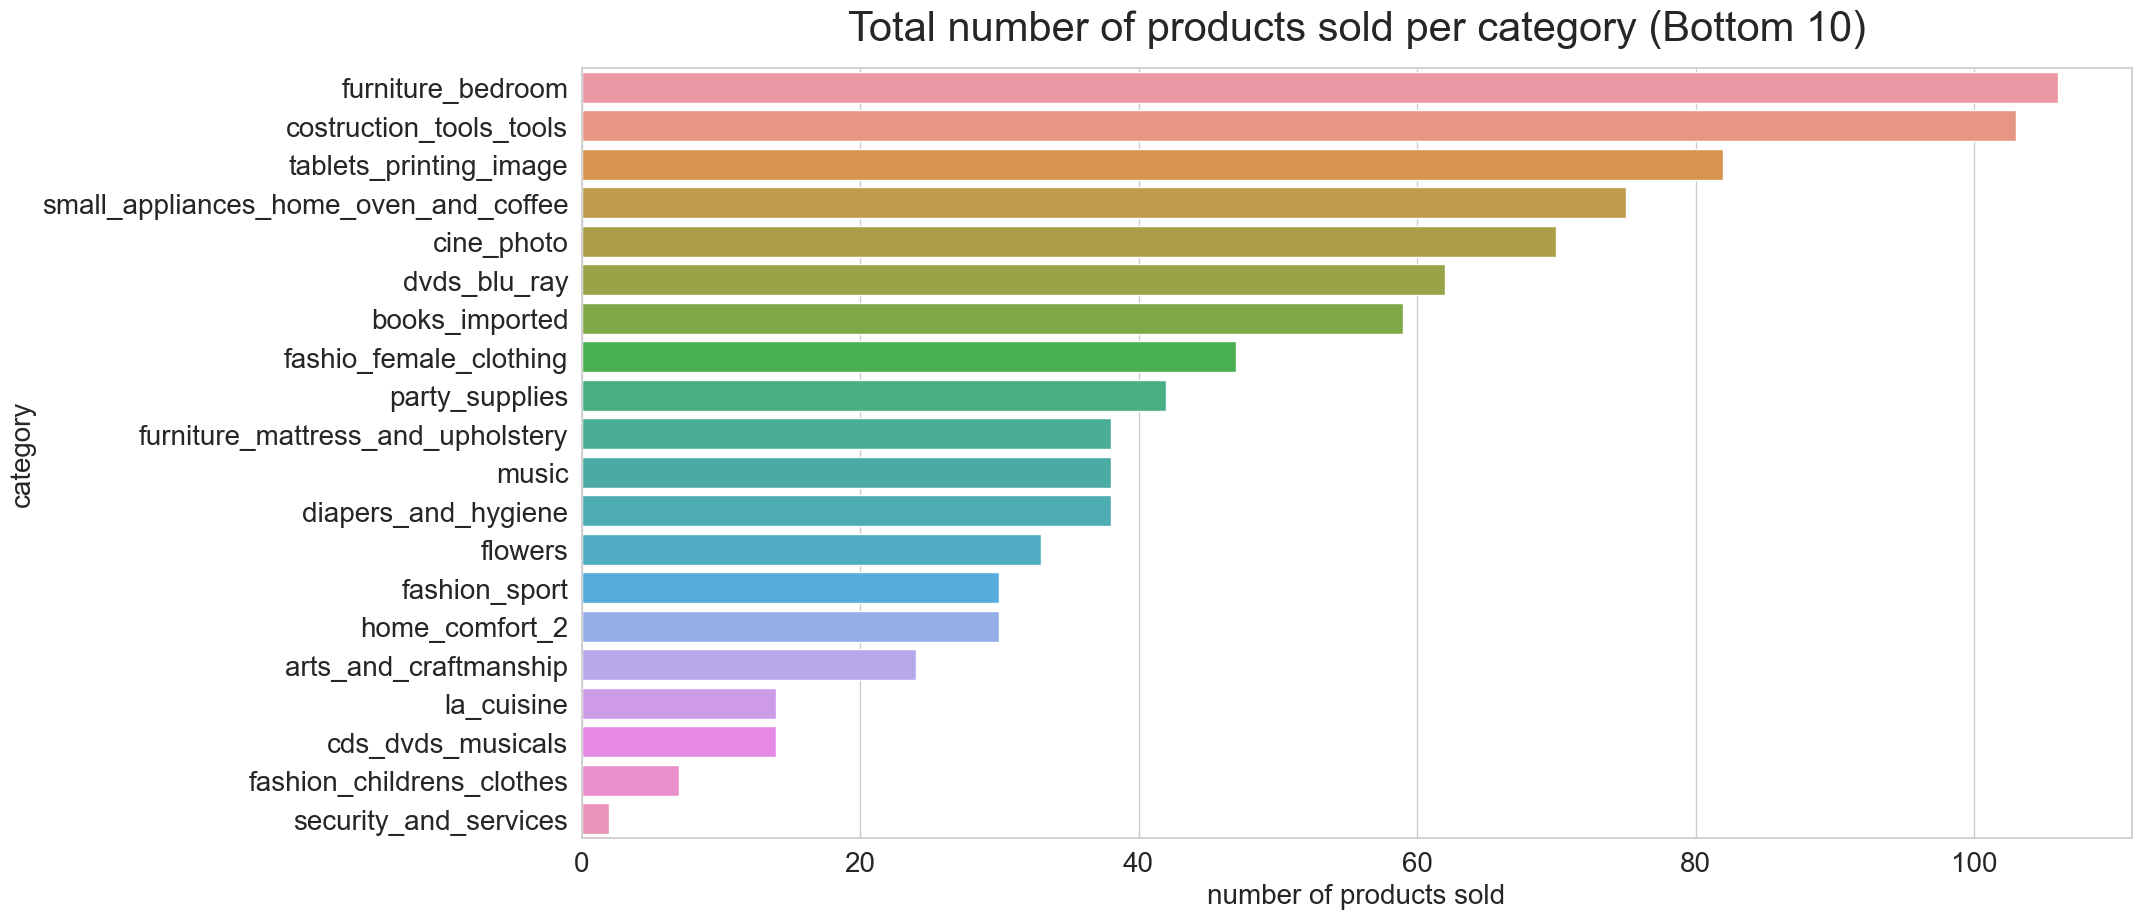

In [19]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (20,10))
sns.barplot(y = bottom_20_quantity['category'],x=bottom_20_quantity['quantity'])
plt.title('Total number of products sold per category (Bottom 10)', fontsize = 30, pad = 20)

plt.xlabel('number of products sold',fontsize=20)
plt.ylabel('category',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## 3.3 - Which categories are generating the most revenue? 

In [22]:
top_20_profits = product_cat.loc[:,['category','profits']].\
                sort_values(by='profits',ascending=False).head(20)
top_20_profits

,category,profits
14,computers,655.979759
64,small_appliances_home_oven_and_coffee,130.861833
45,home_appliances_2,90.479364
0,agro_industry_and_commerce,63.723380
63,small_appliances,46.030373
56,musical_instruments,36.871383
11,cds_dvds_musicals,33.000000
22,costruction_tools_tools,19.240897
70,watches_gifts,16.317368
20,cool_stuff,15.612748


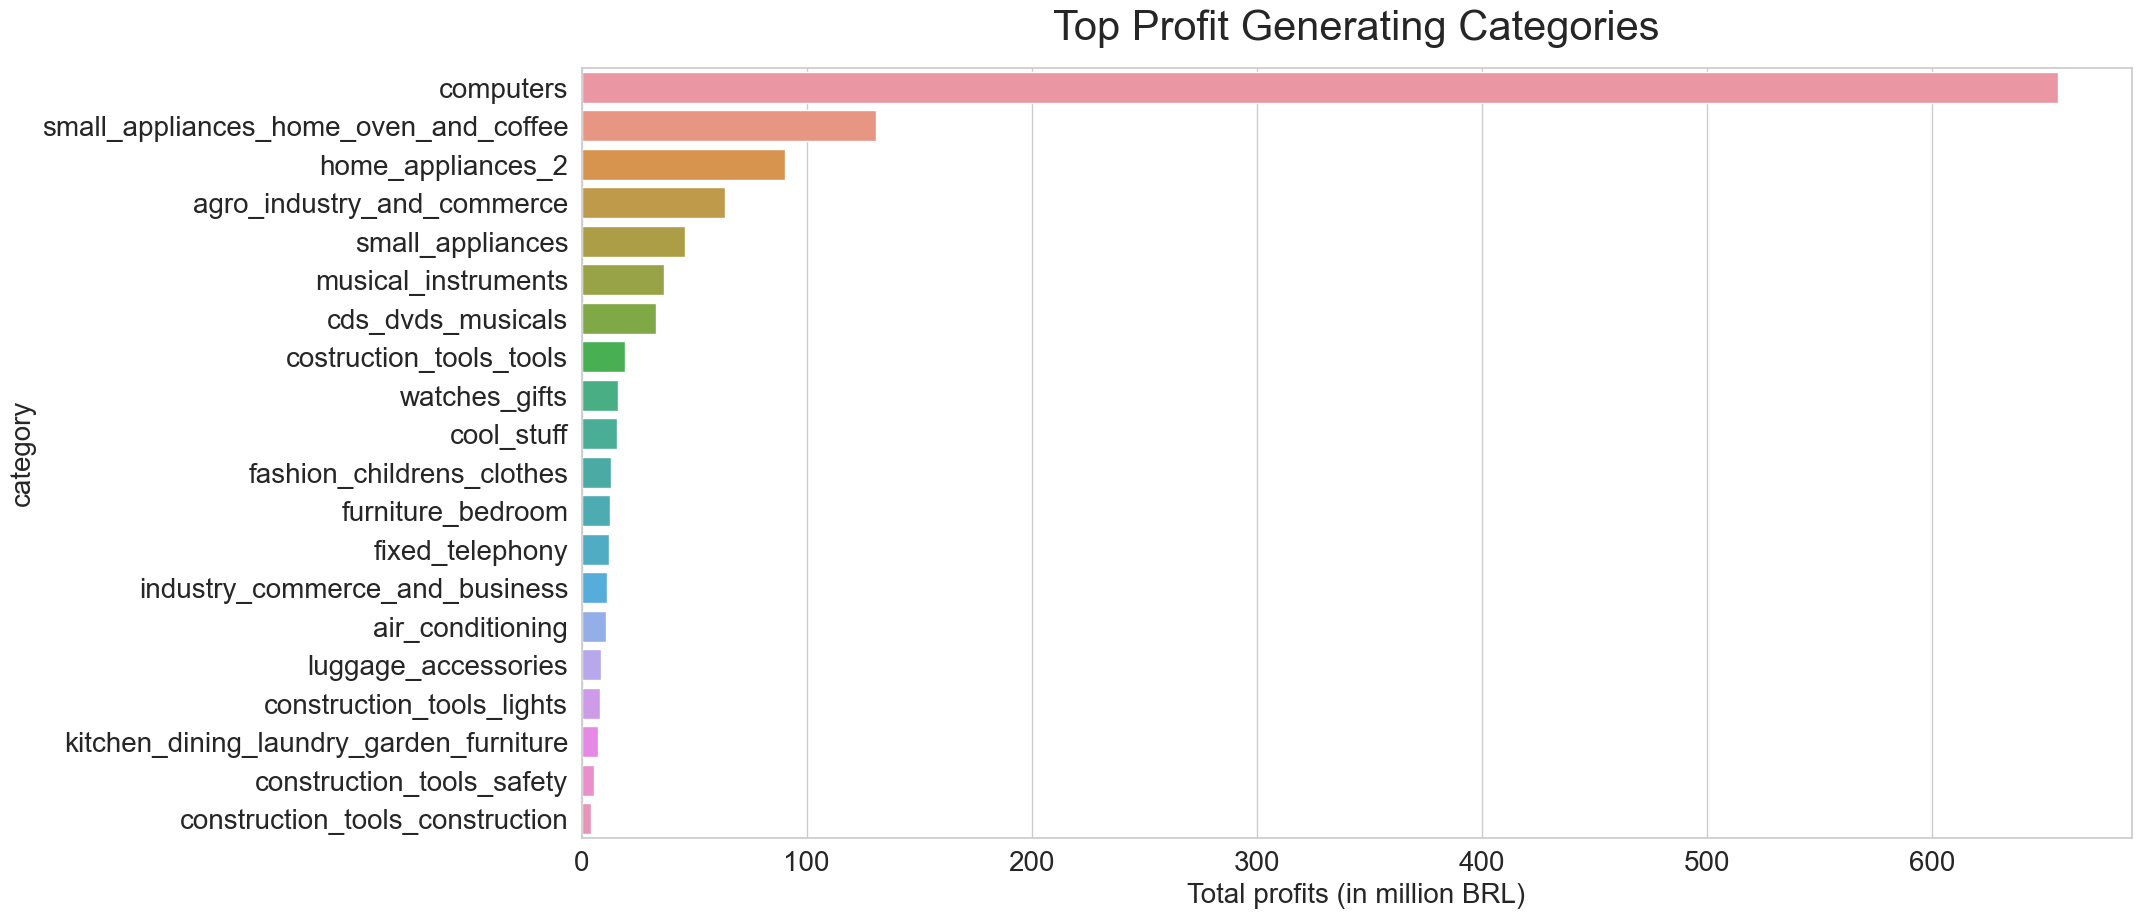

In [28]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (20,10))
sns.barplot(y = top_20_profits['category'],x=top_20_profits['profits'])
plt.title('Top Profit Generating Categories', fontsize = 30, pad = 20)

plt.xlabel('Total profits (in million BRL)',fontsize=20)
plt.ylabel('category',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [24]:
bottom_20_sales = product_cat.loc[:,['category','profits']].\
                sort_values(by='profits',ascending=False).tail(20)
bottom_20_sales

,category,profits
12,christmas_supplies,-16.187871
2,art,-17.333451
39,furniture_decor,-20.478761
15,computers_accessories,-20.565348
33,fashion_underwear_beach,-22.400673
30,fashion_male_clothing,-22.719057
57,office_furniture,-23.970488
27,fashio_female_clothing,-25.347154
24,drinks,-26.101612
36,food,-28.734671


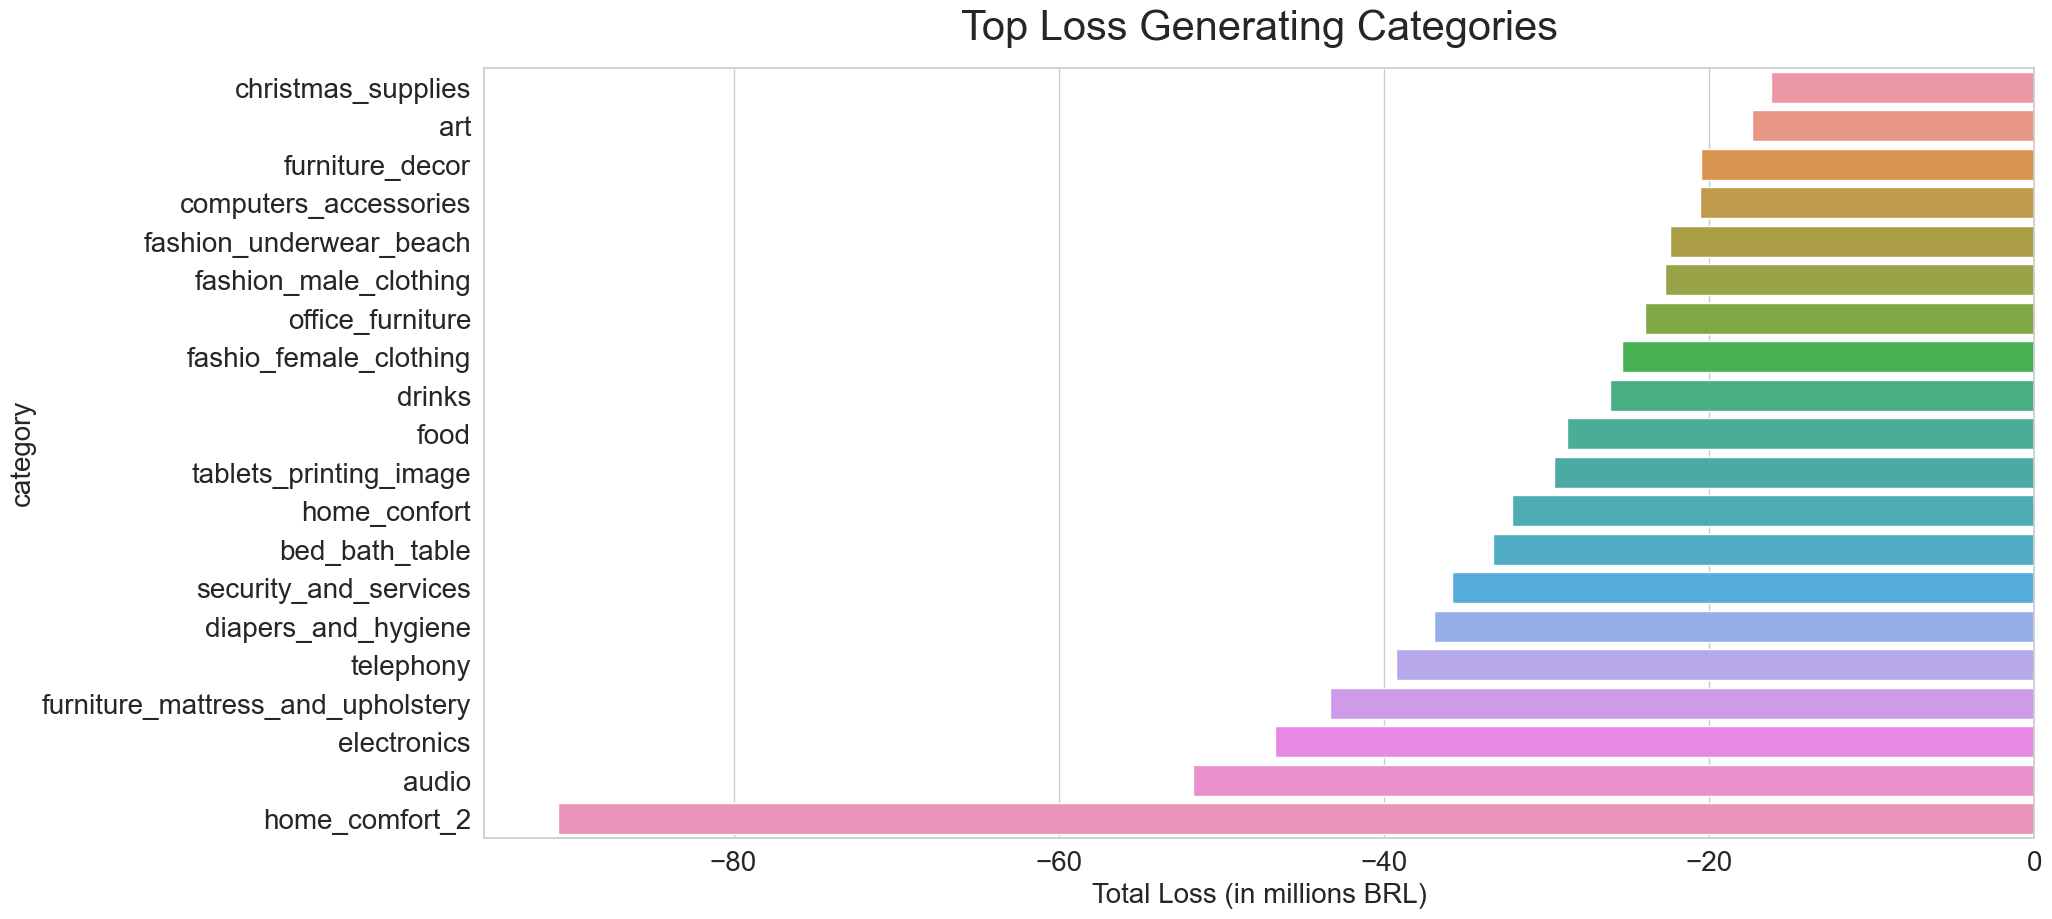

In [29]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (20,10))
sns.barplot(y = bottom_20_sales['category'],x=bottom_20_sales['profits'])
plt.title('Top Loss Generating Categories', fontsize = 30, pad = 20)

plt.xlabel('Total Loss (in millions BRL)',fontsize=20)
plt.ylabel('category',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## 3.3 - Which categories are the best/worst performers in terms of review score?

**❓ What are the best performing product categories?** 

In [55]:
best_categories = round(product_cat[['category','review_score']].sort_values(by='review_score',ascending=False).head(10),2)
best_categories

,category,review_score
29,fashion_childrens_clothes,5.00
46,home_comfort_2,4.72
11,cds_dvds_musicals,4.67
8,books_general_interest,4.48
10,books_technical,4.48
37,food_drink,4.45
9,books_imported,4.41
32,fashion_sport,4.40
53,luggage_accessories,4.36
3,arts_and_craftmanship,4.36


**❓ What are the worst performing product categories?**

- `Furniture-related` categories tend to have lower review score
- `security and services` have lowest review score, but sample size is very small because only few are sold. Difficult to generalize. 
- `Fashion` is low for both female and male, but good for children

In [56]:
worst_categories = round(product_cat[['category','review_score']].sort_values(by='review_score',ascending=False).tail(10),2)
worst_categories

,category,review_score
0,agro_industry_and_commerce,3.92
7,bed_bath_table,3.90
34,fixed_telephony,3.82
47,home_confort,3.80
57,office_furniture,3.77
4,audio,3.76
30,fashion_male_clothing,3.74
27,fashio_female_clothing,3.61
41,furniture_mattress_and_upholstery,3.22
61,security_and_services,2.50


**❓ Let's try to understand why some are performing better than the other**

In [57]:
import plotly.express as px
fig = px.scatter(data_frame = product_cat,
    x="wait_time",
    y="product_volume_cm3",
    #y="product_length_cm",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5,
    hover_name="category"
)
fig.show(renderer='iframe')

**💡 Findings:**
- `security_and_services` and `furniture_mattress_and_upholstery` are particularly bad performers. `Wait time` is pretty high for both. 
- Some categories with large `volume` have low review scores, mostly furniture-related

## 3.4 - Causal Inference

☝️ It seems that `large products` like `office_furniture` and `furniture_mattress_and_upholstery`, which happen to take longer to deliver, are performing worse than other products.

🤔 Are consumers disappointed about these products or by the slow delivery time ❓ 

👉 Run an OLS to model `review_score` :
* to isolate the real contribution of each product category on customer satisfaction, 
* by holding `wait_time` constant.

In [58]:
model2 = smf.ols(formula='review_score ~ C(category) + wait_time', data=products).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     45.94
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:01:49   Log-Likelihood:                -47463.
No. Observations:               31482   AIC:                         9.507e+04
Df Residuals:                   31410   BIC:                         9.567e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  4.3845      0.130     33.694      0.000       4.129       4.640
C(category)[T.air_conditioning]                            0.0615      0.164      0.375      0.707      -0.260       0.383
C(category)[T.art]                                         0.3383      0.201      1.685      0.092      -0.055       0.732
C(category)[T.arts_and_craftmanship]                       0.1858      0.283      0.658      0.511      -0.368       0.740
C(category)[T.audio]                                      -0.0994      0.194     -0.513      0.608      -0.479       0.280
C(category)[T.auto]                                        0.2068      0.132      1.563      0.118      -0.052       0.466
C(category)[T.baby]                                        0.1529      0.135      1.133      0.257      -0.112       0.417
C(category)[T.bed_bath_table]                              0.0124      0.131      0.094      0.925      -0.245       0.270
C(category)[T.books_general_interest]                      0.5706      0.150      3.792      0.000       0.276       0.865
C(category)[T.books_imported]                              0.3296      0.238      1.383      0.167      -0.137       0.797
C(category)[T.books_technical]                             0.5106      0.163      3.127      0.002       0.190       0.831
C(category)[T.cds_dvds_musicals]                           0.7153      1.102      0.649      0.516      -1.444       2.875
C(category)[T.christmas_supplies]                          0.3647      0.190      1.918      0.055      -0.008       0.737
C(category)[T.cine_photo]                                  0.0716      0.251      0.285      0.775      -0.420       0.563
C(category)[T.computers]                                   0.2701      0.241      1.120      0.263      -0.203       0.743
C(category)[T.computers_accessories]                       0.1364      0.133      1.028      0.304      -0.124       0.396
C(category)[T.consoles_games]                              0.2972      0.144      2.058      0.040       0.014       0.580
C(category)[T.construction_tools_construction]             0.1792      0.141      1.270      0.204      -0.097       0.456
C(category)[T.construction_tools_lights]                   0.0319      0.181      0.176      0.860      -0.322       0.386
C(category)[T.construction_tools_safety]                   0.0525      0.175      0.301      0.764      -0.290       0.395
C(category)[T.cool_stuff]                                  0.3096      0.136      2.281      0.023       0.044       0.576
C(category)[T.costruction_tools_garden]                    0.1764      0.175      1.005      0.315      -0.167       0.520
C(catego

👉 Zoom into the coefficients that are statistically significant

Use return_siginificative_coef method from olist/utils.py to zoom into features with p-values lower than 0.05

In [59]:
from olist.utils import return_significative_coef
return_significative_coef(model2)

,variable,p_value,coef
0,Intercept,1.593252e-244,4.384505
8,C(category)[T.books_general_interest],1.496383e-04,0.570564
31,C(category)[T.fashion_shoes],8.083691e-04,0.518896
10,C(category)[T.books_technical],1.770253e-03,0.510570
37,C(category)[T.food_drink],6.053813e-03,0.467034
53,C(category)[T.luggage_accessories],5.319796e-03,0.397271
66,C(category)[T.stationery],7.379422e-03,0.362446
70,C(category)[T.watches_gifts],1.191878e-02,0.335335
56,C(category)[T.musical_instruments],2.684724e-02,0.322184
43,C(category)[T.health_beauty],1.715978e-02,0.314004


**💡 Findings:**

☝️ Furnitures are not in the list of significant coefficients! 

😉 The low review_score for furnitures may result from the delivery rather than the product itself! 

💡On the contrary, `books`, `shoes`, and `food & drinks` are regularly driving higher reviews, even after accounting for generally quicker delivery time. 

---